## Import Necessary Packages 

In [3]:
import pandas as pd 
from gurobipy import Model, GRB, quicksum
import gurobipy as gp 


## Initialize the Model

In [4]:
model = gp.Model()  # Initialize a new model using Gurobi

Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-06


## Load Data from Files using Pandas

For one of the sheets, it was required to change the name of the depot's to their basic identifier for reasons explained in the next step.

In [5]:
# Load data from Excel
TransCostIN = pd.read_csv('/Users/joshuascantlebury/Downloads/TransCostIn.csv', index_col=0)
DepotAbv = ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10','D11', 'D12', 'D13', 'D14', 'D15', 'D16', 'D17', 'D18', 'D19']
TransCostIN.columns = DepotAbv
TransCost = pd.read_csv('/Users/joshuascantlebury/Downloads/TransCost.csv', index_col=0)
FixedCost = pd.read_csv('/Users/joshuascantlebury/Downloads/FixedCost.csv', header=None)
FixedCost2 = pd.read_csv('/Users/joshuascantlebury/Downloads/FixedCost.csv', header=None,index_col=0)
Demand = pd.read_csv('/Users/joshuascantlebury/Downloads/Demand.csv', index_col=0)
Weights = pd.read_csv('/Users/joshuascantlebury/Downloads/Weights.csv',header=None)

## Data Preparation and Label Extraction

After loading the data, the script extracts labels that will be used as identifiers for the data frames. These labels are used for indexing variables in the optimization model:

In [6]:
depots = TransCostIN.columns.to_list()  # Extract depot names
parts = Demand.index.to_list()  # Extract part IDs
customers = Demand.columns.to_list()  # Extract customer IDs
suppliers = TransCostIN.index.tolist()  # Extract supplier IDs
DictPartWeight = Weights.set_index(Weights.columns[0])[Weights.columns[1]].to_dict()  # Map part IDs to their weights


## Model Initialization

In [7]:
m = Model("spare_parts_logistics")  # Initializes a new Gurobi model named "spare_parts_logistics".

## Decision Variables

Depot Usage (d): Binary variables indicating whether each depot is in use.

Supplier to Depot Shipments (sd): Variable representing the amount of parts shipped from suppliers to depots.

Depot to Customer Shipments (dc): Variable representing the amount of parts shipped from depots to customers.

In [8]:
d = m.addVars(depots, vtype=GRB.BINARY, name="DepotInUse")
sd = m.addVars(suppliers, depots, parts, vtype=GRB.CONTINUOUS, name="SupplierDepotShipment")
dc = m.addVars(depots, customers, parts, vtype=GRB.CONTINUOUS, name="DepotCustomerShipment")


## Objective Function

The goal is to minimize the total cost, which consists of:

1.	Fixed Costs for Using Depots: A fixed cost for each depot that is in use.

2.	Transportation Costs from Suppliers to Depots: Costs based on the weight of parts shipped from suppliers to depots.

3.	Transportation Costs from Depots to Customers: Costs based on the weight of parts shipped from depots to customers.


In [9]:
m.setObjective(
    sum(FixedCost2.loc[j,1] * d[j] for j in depots) +
    sum(TransCostIN.loc[s, j] * sd[s, j, p] * DictPartWeight[p]  for s in suppliers for j in depots for p in parts) +
    sum(TransCost.loc[k, j] * dc[j, k, p] * DictPartWeight[p] for j in depots for k in customers for p in parts),
    GRB.MINIMIZE
)


## Constraints

Supplier Weight Limit: With the exception of S1, each supplier can ship a maximum weight of 200,000kg of parts per year.

Depot Capacity Limit: The total shipments through each depot must not exceed its respective capacity.

Demand Fulfillment: The demand for each part at each customer location must be met exactly by shipments from depots.

Service Level: Ensures each customer is within a certain service level constraint of an open depot. This constraint is to be modified to fit service level requirements by changing the cut-off price. Default setting is for 9-hour service time.

Shipments Only If Depot Is Open: Ensures shipments from suppliers to depots and from depots to customers occur only if the depot is open.

Inventory Balance: The total amount received at each depot from all suppliers is equivalent to the total amount shipped out to all customers.

In [10]:
#Supplier Weight Limit: Each supplier (except for the US) can ship up to 200,000 kg of parts per year. 
for s in suppliers:
    if s != "S1":  
        m.addConstr(
            gp.quicksum(sd[s, j, p] * DictPartWeight[p] for p in parts for j in depots) <= 200000,
            name=f"SupplierWeightLimit_{s}"
        )
# Depot Capacity Limit: Each depot's total shipment should not exceed its capacity.
depot_capacity = {depot: 300000 if depot == "D1" else 150000 for depot in depots}


for j in depots:
    m.addConstr(
          gp.quicksum(sd[s, j, p] * d[j] for s in suppliers for p in parts) +
         (gp.quicksum(dc[j, k, p] * d[j] for k in customers for p in parts)) <= depot_capacity[j] * d[j],
        name=f"DepotCapacity_{j}"
    )

#The demand for each part at each customer location must be met exactly by shipments from depots
for p in parts:
    for k in customers:
        m.addConstr(
            gp.quicksum(dc[j, k, p] for j in depots) == Demand.loc[p, k],
            name=f"DemandFulfillment_{p}_{k}"
        )

# Creating a binary parameter indicating if a depot-customer pair is within the service level constraint. This constraint is to be adjusted accordingly to fit the service levels of $4.5,$5,$5.5 and $6.
is_within_service_level = {(k, j): int(TransCost.loc[k, j] <= 5  ) for j in depots for k in customers}

# Service Level Constraint: Ensuring each customer is within 9 hours of an open depot
for k in customers:
    m.addConstr(
        gp.quicksum(is_within_service_level[k,j ] * d[j] for j in depots) >= 1,
        name=f"ServiceLevel_{k}"
    )

# Constraint to ensure that shipments from suppliers to depots only occur if the depot is open
for s in suppliers:
    for j in depots:
        for p in parts:
            # Ensuring shipments are possible only if the depot is open.
            m.addConstr(sd[s, j, p] <= depot_capacity[j] * d[j], f"ShipFromSupplierToDepot_{s}_{j}_{p}")

# Constraint to ensure that shipments from depots to customers only occur if the depot is open
for j in depots:
    for k in customers:
        for p in parts:
            # Ensuring shipments are possible only if the depot is open.
            m.addConstr(dc[j, k, p] <= depot_capacity[j] * d[j], f"ShipFromDepotToCustomer_{j}_{k}_{p}")


#To ensure the total amount received at each depot from all suppliers is equivalent to the total amount shipped out to all customers
for j in depots:
    for p in parts:
        # Total received at depot j for part p from all suppliers
        total_received = gp.quicksum(sd[s, j, p] for s in suppliers)
        
        # Total shipped from depot j for part p to all customers
        total_shipped = gp.quicksum(dc[j, k, p] for k in customers)
        
        m.addConstr(total_received == total_shipped, name=f"InventoryBalance_{j}_{p}")

## Update the Model


In [11]:
m.update()

## Optimize the Model

In [12]:
m.optimize()

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 23.3.0 23D56)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 338587 rows, 320948 columns and 1282363 nonzeros
Model fingerprint: 0xd92ffaf2
Model has 19 quadratic constraints
Variable types: 320929 continuous, 19 integer (19 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+05, 3e+05]
  Objective range  [1e+00, 4e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 2e+05]
Presolve removed 242728 rows and 230489 columns
Presolve time: 0.67s
Presolved: 189073 rows, 186409 columns, 726689 nonzeros
Presolved model has 5510 SOS constraint(s)
Variable types: 183635 continuous, 2774 integer (2774 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.

## Identifying Open Depots


In [13]:
depots_in_use = []
for j in depots:
    if d[j].X == 1:  # Checks if the decision variable for depot usage is set to 1 (open)
        depots_in_use.append(j)
        print(f"Depot {j} is in use.")
    else:
        print(f"Depot {j} is not in use.")


Depot D1 is in use.
Depot D2 is in use.
Depot D3 is in use.
Depot D4 is in use.
Depot D5 is not in use.
Depot D6 is not in use.
Depot D7 is not in use.
Depot D8 is not in use.
Depot D9 is not in use.
Depot D10 is not in use.
Depot D11 is not in use.
Depot D12 is not in use.
Depot D13 is not in use.
Depot D14 is not in use.
Depot D15 is not in use.
Depot D16 is in use.
Depot D17 is in use.
Depot D18 is not in use.
Depot D19 is not in use.


## Printing the Objective Function Value

In [14]:
objectivefunctionvalue = m.objVal
print(f"The Optimal Objective Value ${round(objectivefunctionvalue,2)}")


The Optimal Objective Value $5004750.46


## Breaking Down Costs

In [15]:
Fixed_Costs_Of_Opening_Depots = sum(FixedCost2.loc[j, 1] * d[j].X for j in depots)
VariableTransportationCosts = sum(TransCostIN.loc[s, j] * sd[s, j, p].X * DictPartWeight[p] for s in suppliers for j in depots for p in parts) + sum(TransCost.loc[k, j] * dc[j, k, p].X * DictPartWeight[p] for j in depots for k in customers for p in parts)

print("Fixed Costs of Opening Depots: $", round(Fixed_Costs_Of_Opening_Depots,2))
print("Variable Transportation Costs: $", round(VariableTransportationCosts,2))


Fixed Costs of Opening Depots: $ 1937637.0
Variable Transportation Costs: $ 3067113.46


## Total Parts Through Each Depot

In [16]:
# Initialize a dictionary to store the total amount of parts passing through each depot
depot_total_parts = {depot: 0 for depot in depots}

# Calculate the total parts passing through each depot
for j in depots:
    for s in suppliers:
        for p in parts:
            depot_total_parts[j] += sd[s, j, p].X 
    
    for k in customers:
        for p in parts:
            depot_total_parts[j] += dc[j, k, p].X 

# Print the total parts passing through each depot only if it's greater than 0
for depot, total_parts in depot_total_parts.items():
    if total_parts > 0: 
        print(f"Total parts passing through {depot}: {round(total_parts,0)} units")

Total weight passing through D1: 300000.0 units
Total weight passing through D2: 150000.0 units
Total weight passing through D3: 59901.0 units
Total weight passing through D4: 141643.0 units
Total weight passing through D16: 150000.0 units
Total weight passing through D17: 150000.0 units


## Total Part Weight Through Each Depot

In [17]:
# Initialize a dictionary to store the total weight of parts passing through each depot
depot_total_weight = {depot: 0 for depot in depots}

# Calculate the total weight passing through each depot
for j in depots:
    for s in suppliers:
        for p in parts:
            depot_total_weight[j] += sd[s, j, p].X * DictPartWeight[p]  
    
    for k in customers:
        for p in parts:
            depot_total_weight[j] += dc[j, k, p].X * DictPartWeight[p] 

# Print the total weight of parts passing through each depot only if it's greater than 0
for depot, total_weight in depot_total_weight.items():
    if total_weight > 0: 
        print(f"Total weight passing through {depot}: {round(total_weight,2)} kg")

Total weight passing through D1: 519004.8 kg
Total weight passing through D2: 252319.14 kg
Total weight passing through D3: 97717.06 kg
Total weight passing through D4: 228051.27 kg
Total weight passing through D16: 248064.3 kg
Total weight passing through D17: 237623.95 kg


## Depot Utilization

Understanding the operating capacity each depot.

In [18]:
# Determine the capacity of each depot
depot_capacity = {depot: 300000 if depot == "D1" else 150000 for depot in depots}

# Calculate and print the capacity utilization as a percentage
depot_utilizations = {}
for depot in depots:
    if d[depot].X > 0.5:  # Check if the depot is considered open based on optimization result
        utilization_percentage = (depot_total_parts[depot] / depot_capacity[depot]) * 100
        depot_utilizations[depot] = utilization_percentage
        print(f"Depot {depot}: Capacity Utilization = {utilization_percentage:.2f}%")

Depot D1: Capacity Utilization = 100.00%
Depot D2: Capacity Utilization = 100.00%
Depot D3: Capacity Utilization = 39.93%
Depot D4: Capacity Utilization = 94.43%
Depot D16: Capacity Utilization = 100.00%
Depot D17: Capacity Utilization = 100.00%


In [19]:
# Determine the capacity of each depot
depot_capacity = {depot: 300000 if depot == "D1" else 150000 for depot in depots}

# Calculate capacity utilization as a percentage for each depot
depot_utilizations = {}
for depot in depots:
    if d[depot].X > 0.5:  # Check if the depot is considered open based on optimization result
        utilization_percentage = (depot_total_parts[depot] / depot_capacity[depot]) * 100
        depot_utilizations[depot] = utilization_percentage

# Print capacity utilization for each open depot
for depot, utilization in depot_utilizations.items():
    print(f"Depot {depot}: Capacity Utilization = {utilization:.2f}%")

# Identify and print the depot(s) operating at the highest capacity
max_utilization = max(depot_utilizations.values()) if depot_utilizations else 0
highest_capacity_depots = [depot for depot, utilization in depot_utilizations.items() if utilization == max_utilization]

Depot D1: Capacity Utilization = 100.00%
Depot D2: Capacity Utilization = 100.00%
Depot D3: Capacity Utilization = 39.93%
Depot D4: Capacity Utilization = 94.43%
Depot D16: Capacity Utilization = 100.00%
Depot D17: Capacity Utilization = 100.00%

Depot(s) operating at the highest capacity utilization (100.00%): D2


## Key Customer Identification
Identify the top 15 most important customers based on total parts ordered.

In [20]:
# Initialize a dictionary to hold the total quantity of parts ordered by each customer
customer_total_parts_ordered = {customer: 0 for customer in customers}
customer_allocation = {customer: [] for customer in customers}

for j in depots:
    for k in customers:
        for p in parts:
            if dc[j, k, p].X > 0:  
                customer_total_parts_ordered[k] += dc[j, k, p].X  
                if j not in customer_allocation[k]:
                    customer_allocation[k].append(j)

# Sort customers by the total parts ordered in descending order
sorted_customers = sorted(customer_total_parts_ordered.items(), key=lambda x: x[1], reverse=True)


top_15_customers = sorted_customers[:15]

# Print the top 15 customers, their total parts ordered, and which depot(s) service them
for customer, total_parts_ordered in top_15_customers:
    allocated_depots_str = ", ".join(customer_allocation[customer]) if customer_allocation[customer] else "No depots allocated"
    print(f"Customer {customer} ordered a total of {round(total_parts_ordered,0)} parts and is serviced by depot(s): {allocated_depots_str}")


Customer US ordered a total of 196162.0 parts and is serviced by depot(s): D1, D16
Customer GB ordered a total of 79114.0 parts and is serviced by depot(s): D2, D17
Customer CA ordered a total of 51891.0 parts and is serviced by depot(s): D1, D4
Customer DE ordered a total of 24426.0 parts and is serviced by depot(s): D2
Customer AU ordered a total of 15980.0 parts and is serviced by depot(s): D3
Customer JP ordered a total of 15251.0 parts and is serviced by depot(s): D4
Customer NL ordered a total of 13810.0 parts and is serviced by depot(s): D2
Customer CN ordered a total of 5719.0 parts and is serviced by depot(s): D4
Customer NO ordered a total of 5290.0 parts and is serviced by depot(s): D2, D4, D17
Customer ES ordered a total of 5070.0 parts and is serviced by depot(s): D2
Customer CH ordered a total of 4468.0 parts and is serviced by depot(s): D2
Customer TW ordered a total of 4214.0 parts and is serviced by depot(s): D4
Customer AT ordered a total of 3867.0 parts and is servic

Identify all customers based on parts ordered

In [27]:
# Print the customersand which depot(s) service them
for customer, total_parts_ordered in sorted_customers:
    allocated_depots_str = ", ".join(customer_allocation[customer]) if customer_allocation[customer] else "No depots allocated"
    print(f"Customer {customer} is serviced by depot(s): {allocated_depots_str}")


Customer US is serviced by depot(s): D1, D16
Customer GB is serviced by depot(s): D2, D17
Customer CA is serviced by depot(s): D1, D4
Customer DE is serviced by depot(s): D2
Customer AU is serviced by depot(s): D3
Customer JP is serviced by depot(s): D4
Customer NL is serviced by depot(s): D2
Customer CN is serviced by depot(s): D4
Customer NO is serviced by depot(s): D2, D4, D17
Customer ES is serviced by depot(s): D2
Customer CH is serviced by depot(s): D2
Customer TW is serviced by depot(s): D4
Customer AT is serviced by depot(s): D2
Customer FR is serviced by depot(s): D2
Customer PG is serviced by depot(s): D3
Customer ZA is serviced by depot(s): D4
Customer IN is serviced by depot(s): D4
Customer IL is serviced by depot(s): D2, D4
Customer AE is serviced by depot(s): D2, D4
Customer BR is serviced by depot(s): D3, D16
Customer AG is serviced by depot(s): D1, D3
Customer NZ is serviced by depot(s): D3
Customer SG is serviced by depot(s): D4
Customer MX is serviced by depot(s): D3,

## Model Complexity

In [21]:
num_variables = m.NumVars
num_constraints = m.NumConstrs

print(f"The model has {num_variables} variables.")
print(f"The model has {num_constraints} constraints.")


The model has 320948 variables.
The model has 338587 constraints.


## Service Level Sensitivity 

To meet specific requirements, the service level constraint within the model can be changed by modifying the cutoff point to fit the acceptable threshold for service levels. This constraint translates all values below the cutoff into binary variables,  which will allow for the model to select depots that meet the service level criteria.
This flexible approach will allow for the model to accommodate varying levels of service efficiency without having to make modifications to the code.

In [31]:

service_level_table = {
    "Cost": ["$4.5", "$5", "$5.5", "$6"],
    "Depots Open": ["Infeasible", "D1, D2, D3, D4, D16, D17", "D1, D4, D8, D10, D16, D17", "D1, D4, D8, D10, D16, D17"],
    "Total Cost": ["Infeasible", "$5,004,750.46", "$4,842,866.71", "$4,842,866.71"]
}

ServiceLevelSensitivity = pd.DataFrame(service_level_table)

ServiceLevelSensitivity

,Cost,Depots Open,Total Cost
0,$4.5,Infeasible,Infeasible
1,$5,"D1, D2, D3, D4, D16, D17","$5,004,750.46"
2,$5.5,"D1, D4, D8, D10, D16, D17","$4,842,866.71"
3,$6,"D1, D4, D8, D10, D16, D17","$4,842,866.71"


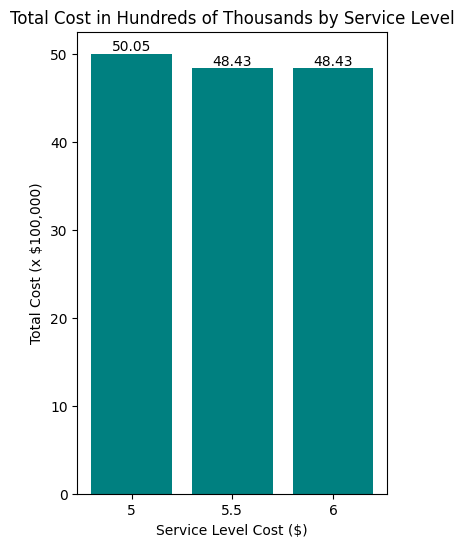

In [30]:
import matplotlib.pyplot as plt

service_levels = ['5', '5.5', '6']
total_costs = [5004750.46, 4842866.71, 4842866.71]

costs_hundreds_of_thousands = [cost / 100000 for cost in total_costs]

plt.figure(figsize=(4, 6))
bars = plt.bar(service_levels, costs_hundreds_of_thousands, color='teal')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# Title and labels
plt.title('Total Cost in Hundreds of Thousands by Service Level')
plt.xlabel('Service Level Cost ($)')
plt.ylabel('Total Cost (x $100,000)')


# Display the plot
plt.show()


We recommend increasing the maximum flight time to 12 hours, assuming all costs have been factored in. In doing so, the operating costs are projected to decrease by approximately $161,883.25, which is around 3% compared to the operating costs at the current service level.